In [ ]:
!pip install --upgrade setuptools pip --user

!pip install nvidia-pyindex
!pip install --upgrade nvidia-tensorrt
!pip install pycuda

!pip install transformers diffusers scipy

In [ ]:
# make sure you're logged in with `huggingface-cli login`
!huggingface-cli login

In [2]:
!nvidia-smi

Tue Oct 18 13:09:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://huggingface.co/kamalkraj/stable-diffusion-v1-4-onnx/resolve/main/models.tar.gz
!tar -xf models.tar.gz

# Convert Unet Onnx model to TensorRT

In [ ]:
import torch
import tensorrt as trt
import os, sys, argparse
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit  # without this, "LogicError: explicit_context_dependent failed: invalid device context - no currently active context?"
from time import time

onnx_model = "./models/unet/1/unet.onnx"
engine_filename = "unet_new.engine"


def convert_model():
    batch_size = 1
    height = 512
    width = 512
    latents_shape = (batch_size * 2, 4, height // 8, width // 8)
    embed_shape = (batch_size * 2, 64, 768)
    timestep_shape = (batch_size,)

    TRT_LOGGER = trt.Logger(trt.Logger.INFO)
    TRT_BUILDER = trt.Builder(TRT_LOGGER)

    network = TRT_BUILDER.create_network(
        1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    )
    onnx_parser = trt.OnnxParser(network, TRT_LOGGER)
    parse_success = onnx_parser.parse_from_file(onnx_model)
    for idx in range(onnx_parser.num_errors):
        print(onnx_parser.get_error(idx))
    if not parse_success:
        sys.exit("ONNX model parsing failed")
    print("Load Onnx model done")

    config = TRT_BUILDER.create_builder_config()
    profile = TRT_BUILDER.create_optimization_profile()
    profile.set_shape("sample", latents_shape, latents_shape, latents_shape)
    profile.set_shape("encoder_hidden_states", embed_shape, embed_shape, embed_shape)
    profile.set_shape("timestep", timestep_shape, timestep_shape, timestep_shape)
    config.add_optimization_profile(profile)

    config.set_flag(trt.BuilderFlag.FP16)
    serialized_engine = TRT_BUILDER.build_serialized_network(network, config)

    ## save TRT engine
    with open(engine_filename, "wb") as f:
        f.write(serialized_engine)
    print(f"Engine is saved to {engine_filename}")


convert_model()

# TensorRT inference

In [ ]:
!git clone https://github.com/stochasticai/x-stable-diffusion.git
%cd x-stable-diffusion
%cd TensorRT

In [ ]:
!python3 demo.py --trt_unet_save_path ../../unet_new.engine

Inference time is about 10s for a sample. Check you output image at image_generated.png

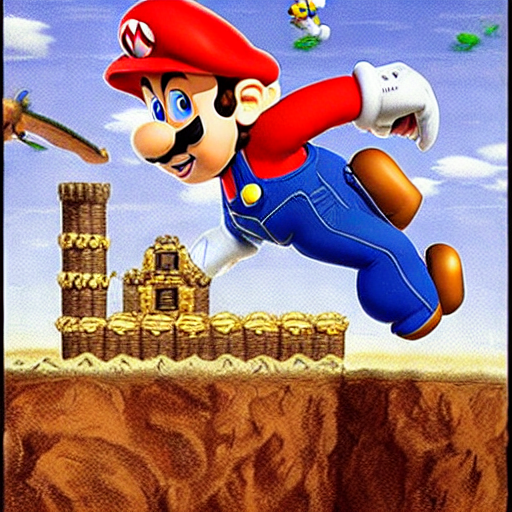

In [11]:
from IPython.display import Image, display

display(Image("image_generated.png"))

# Pytorch inference

In [10]:
# make sure you're logged in with `huggingface-cli login`
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", torch_type=torch.float16, revision="fp16"
)
pipe = pipe.to("cuda")

prompt = "aSuper Mario learning to fly in an airport, Painting by Leonardo Da Vinci"
image = pipe(prompt).images[0]
image.save("image_generated_pytorch.png")

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


  0%|          | 0/51 [00:00<?, ?it/s]

Inference time of Pytorch fp16 model on T4 gpu is 28s.

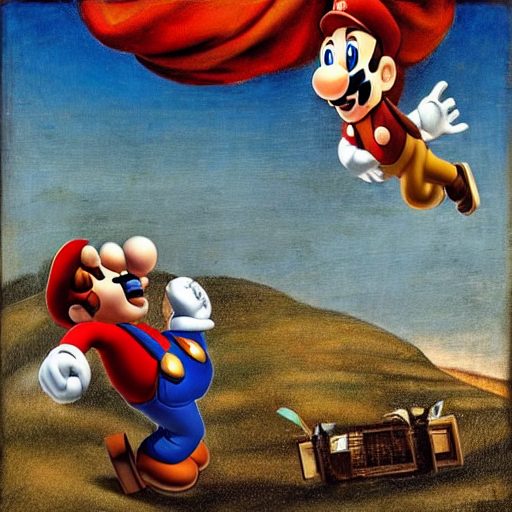

In [12]:
from IPython.display import Image, display

display(Image("image_generated_pytorch.png"))

# Conclusion



With TensorRT model, we can speed up 3 times the Stable Diffusion pipeline on T4 GPU.

